# **Processamento Digital de Imagens - 2023.2**
# Implementação de um codificador de imagem simples


- Equipe:
  - Emanuel
  - Frank Bruno Ferreira Boa Morte (202006840007)
  - Mercedes Maria Barbosa Diniz (201906840030)

## Bibliotecas

In [25]:
# Bibliotecas:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import scipy

## Importando a Imagemde teste

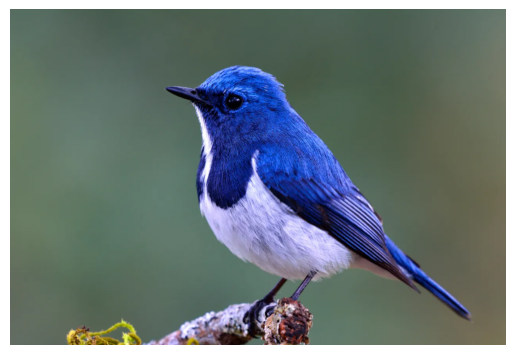

In [27]:
nome = 'passaro_azul.bmp' # nome da imagem
img_original = cv2.imread(nome) # formato BGR (padrão utilizado pelo OpenCV)

# converte a imagem do formato BGR p/ o RGB
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Exibindo a imagem
plt.imshow(img_original_rgb)
plt.axis('off')
plt.show()

## PSNR (Peak Signal-to-Noise Ratio)

Métrica comumente usada para medir a qualidade de uma imagem comprimida ou reconstruída em relação a uma imagem original de referência. Ele calcula a relação sinal-ruído entre as duas imagens, levando em consideração o erro quadrático médio (MSE) entre os pixels das imagens. Quanto maior o valor do PSNR, menor é a diferença perceptual entre as imagens e, portanto, maior é a qualidade da imagem reconstruída.

Formula:

$ PSNR = 10\times log_{10}(\frac{MAX^{2}}{MSE})$

onde:
- $MAX$: o valor máximo que um pixel pode ter na imagem
- $MSE$: o erro médio quadrático entre as duas imagens


In [26]:
def calculaPSNR(img1, img2):
    # Verificando se as imagens têm o mesmo tamanho
    if img1.shape != img2.shape:
        raise ValueError("As imagens devem ter o mesmo tamanho.")

    # Convertendo as imagens para o tipo float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Calculando o erro quadrático médio (MSE)
    mse = np.mean((img1 - img2) ** 2)

    # Verificando se o MSE é zero
    if mse == 0:
        return float('inf')  # PSNR é infinito quando MSE é zero

    # Calculando o PSNR
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel**2)/mse) # em dB

    return psnr

## 1ª Etapa: **Conversão de Mapas de Cor**


### Definições

**Mapa de Cores RGB**:

O mapa de cores RGB (Red, Green, Blue) é o mais comumente usado para representar imagens digitais. Ele é baseado na combinação de três canais de cor primários: vermelho, verde e azul. Cada canal representa a intensidade dessas cores em uma escala de 0 a 255. Ao combinar esses três canais, é possível criar uma ampla gama de cores, permitindo uma representação visualmente rica das imagens.

**Mapa de Cores YCbCr**:

O mapa de cores YCbCr é um espaço de cores usado para representar imagens de forma mais eficiente em termos de armazenamento e transmissão de dados. Ele é composto por três canais: Y (luminância), Cb (crominância azul) e Cr (crominância vermelha). O canal Y representa a informação de brilho ou luminosidade da imagem, enquanto os canais Cb e Cr representam as informações de diferença de cor em relação à luminância. A representação separada da luminância e da crominância permite a aplicação de técnicas de compressão com perdas sem afetar significativamente a qualidade perceptual da imagem.


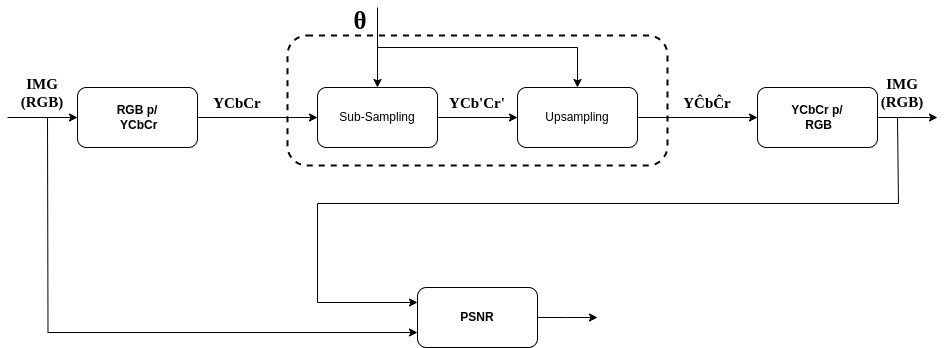

### Implementação

In [28]:
def RGB_to_YCrCb(img):
    # Conversão RGB para YCrCb
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return img_YCrCb

In [29]:
def subSampling(img, theta):
    # Separando as componentes:
    Y, Cr, Cb = cv2.split(img)

    # Sub-amostragem
    if theta == '4:4:4':
        return Y, Cr, Cb
    elif theta == '4:2:2':
        # Elimina as colunas pares das componentes Cb e Cr
        # matriz[início_linha:fim_linha:passo_linha, início_coluna:fim_coluna:passo_coluna]
        Cr_subsampled = Cr[:, ::2]
        Cb_subsampled = Cb[:, ::2]
        return Y, Cr_subsampled, Cb_subsampled

    elif theta == '4:2:0':
        # Elimina as colunas e as linhas pares das componentes Cb e Cr
        # matriz[início_linha:fim_linha:passo_linha, início_coluna:fim_coluna:passo_coluna]
        Cr_subsampled = Cr[::2, ::2]
        Cb_subsampled = Cb[::2, ::2]
        return Y, Cr_subsampled, Cb_subsampled
    else:
        raise ValueError("Theta deve ser '4:4:4', '4:2:2' ou '4:2:0'.")

In [30]:
def upSampling(Y, Cr, Cb, theta):
    # Super-amostragem
    if theta == '4:4:4':
        return Y, Cr, Cb
    elif theta == '4:2:2':
        # Duplicar as colunas eliminadas com interpolação bilinear
        Cr_upsampled = cv2.resize(Cr, None, fx=2, fy=1, interpolation=0)
        Cb_upsampled = cv2.resize(Cb, None, fx=2, fy=1, interpolation=0)
        return Y, Cr_upsampled, Cb_upsampled
    elif theta == '4:2:0':
        # Duplicar as colunas e linhas eliminadas com interpolação bilinear
        Cr_upsampled = cv2.resize(Cr, None, fx=2, fy=2, interpolation=0)
        Cb_upsampled = cv2.resize(Cb, None, fx=2, fy=2, interpolation=0)
        return Y, Cr_upsampled, Cb_upsampled
    else:
        raise ValueError("Theta deve ser '4:4:4', '4:2:2' ou '4:2:0'.")

In [31]:
def YCrCb_to_RGB(img):
    # Conversão YCrCb para RGB
    img_RGB = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    return img_RGB

### Testes

#### **1ª Etapa**: Conversão RGB para YCrCb

In [32]:
# Convertendo de RGB p/ YCrCb
img_YCrCb = RGB_to_YCrCb(img_original_rgb)
Y_nomal, Cr_nomal, Cb_nomal = cv2.split(img_YCrCb)

#### **2ª Etapa**: Sub Sampling

In [33]:
Y_444, Cr_444, Cb_444 = subSampling(img_YCrCb, '4:4:4')
Y_422, Cr_422, Cb_422 = subSampling(img_YCrCb, '4:2:2')
Y_420, Cr_420, Cb_420 = subSampling(img_YCrCb, '4:2:0')

##### **Teste**: Avaliando se a resolução cromatica é reduzida após o estado de Sub Sampling

In [34]:
# Avaliando se a resolução cromatica é reduzida
print(f'Dimensões antes: Y:{Y_nomal.shape}, Cb:{Cb_nomal.shape}, Cr:{Cr_nomal.shape}\n')
print('Dimensões após a etapa sub-sample:')
print(f'[4:4:4]: Y:{Y_444.shape}, Cb:{Cb_444.shape}, Cr:{Cr_444.shape}')
print(f'[4:2:2]: Y:{Y_422.shape}, Cb:{Cb_422.shape}, Cr:{Cr_422.shape}')
print(f'[4:2:0]: Y:{Y_420.shape}, Cb:{Cb_420.shape}, Cr:{Cr_420.shape}')

Dimensões antes: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)

Dimensões após a etapa sub-sample:
[4:4:4]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)
[4:2:2]: Y:(574, 848), Cb:(574, 424), Cr:(574, 424)
[4:2:0]: Y:(574, 848), Cb:(287, 424), Cr:(287, 424)


No caso do sub-sample **4:4:4**, as dimensões das componentes Y, Cb e Cr permaneceram as mesmas, indicando que não houve redução de amostras.

No sub-sample **4:2:2**, as dimensões das componentes Y permaneceram as mesmas, mas as dimensões das componentes Cb e Cr foram reduzidas pela metade. Isso indica que a cada duas colunas, uma foi eliminada nas componentes Cb e Cr.

No sub-sample **4:2:0**, além da redução pela metade das colunas, também ocorreu a redução pela metade das linhas nas componentes Cb e Cr. As dimensões das componentes Cb e Cr ficaram com a metade do número de linhas e colunas em relação à componente Y.

#### **3ª Etapa**: Up Sampling

In [35]:
Y_444, Cr_444, Cb_444 = upSampling(Y_444, Cr_444, Cb_444, '4:4:4')
Y_422, Cr_422, Cb_422 = upSampling(Y_422, Cr_422, Cb_422, '4:2:2')
Y_420, Cr_420, Cb_420 = upSampling(Y_420, Cr_420, Cb_420, '4:2:0')

##### Testando subSampling e upSampling

In [36]:
def imprimir_matriz(matriz):
    for linha in matriz:
        for valor in linha:
            print(valor, end=" ")
        print()

matriz = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
          [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
          [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
          [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
          [61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
          [71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
          [81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
          [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]],dtype='uint8')

#matriz_subsampled = matriz[:, ::2]
#matriz_upsampled = cv2.resize(matriz_subsampled, None, fx=2, fy=1, interpolation=cv2.INTER_LINEAR)

matriz_subsampled = matriz[::2, ::2]
matriz_upsampled = cv2.resize(matriz_subsampled, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)


In [37]:
imprimir_matriz(matriz)

1 2 3 4 5 6 7 8 9 10 
11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 
31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 
51 52 53 54 55 56 57 58 59 60 
61 62 63 64 65 66 67 68 69 70 
71 72 73 74 75 76 77 78 79 80 
81 82 83 84 85 86 87 88 89 90 
91 92 93 94 95 96 97 98 99 100 


In [38]:
imprimir_matriz(matriz_subsampled)

1 3 5 7 9 
21 23 25 27 29 
41 43 45 47 49 
61 63 65 67 69 
81 83 85 87 89 


In [39]:
imprimir_matriz(matriz_upsampled)

1 1 2 3 4 5 6 7 8 9 
6 6 7 8 9 10 11 12 13 14 
16 16 17 18 19 20 21 22 23 24 
26 26 27 28 29 30 31 32 33 34 
36 36 37 38 39 40 41 42 43 44 
46 46 47 48 49 50 51 52 53 54 
56 56 57 58 59 60 61 62 63 64 
66 66 67 68 69 70 71 72 73 74 
76 76 77 78 79 80 81 82 83 84 
81 81 82 83 84 85 86 87 88 89 


##### **Teste**: Avaliando se a resolução cromatica é restaurada após o estado de Up Sampling

In [40]:
# Avaliando se a resolução cromatica é restaurada
print(f'Dimensões antes: Y:{Y_nomal.shape}, Cb:{Cb_nomal.shape}, Cr:{Cr_nomal.shape}\n')
print('Dimensões após a etapa up-sample:')
print(f'[4:4:4]: Y:{Y_444.shape}, Cb:{Cb_444.shape}, Cr:{Cr_444.shape}')
print(f'[4:2:2]: Y:{Y_422.shape}, Cb:{Cb_422.shape}, Cr:{Cr_422.shape}')
print(f'[4:2:0]: Y:{Y_420.shape}, Cb:{Cb_420.shape}, Cr:{Cr_420.shape}')

Dimensões antes: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)

Dimensões após a etapa up-sample:
[4:4:4]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)
[4:2:2]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)
[4:2:0]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)


#### **4ª Etapa**: Conversão de YCbCr para RGB

In [41]:
# Transformando de volta em imagem
img_444 = cv2.merge([Y_444, Cr_444, Cb_444])
img_422 = cv2.merge([Y_422, Cr_422, Cb_422])
img_420 = cv2.merge([Y_420, Cr_420, Cb_420])

# Convertendo p/ RGB
img_decodficada_444 = YCrCb_to_RGB(img_444)
img_decodficada_422 = YCrCb_to_RGB(img_422)
img_decodficada_420 = YCrCb_to_RGB(img_420)

#### Avaliando a qualidade

##### Exibindo as imagens

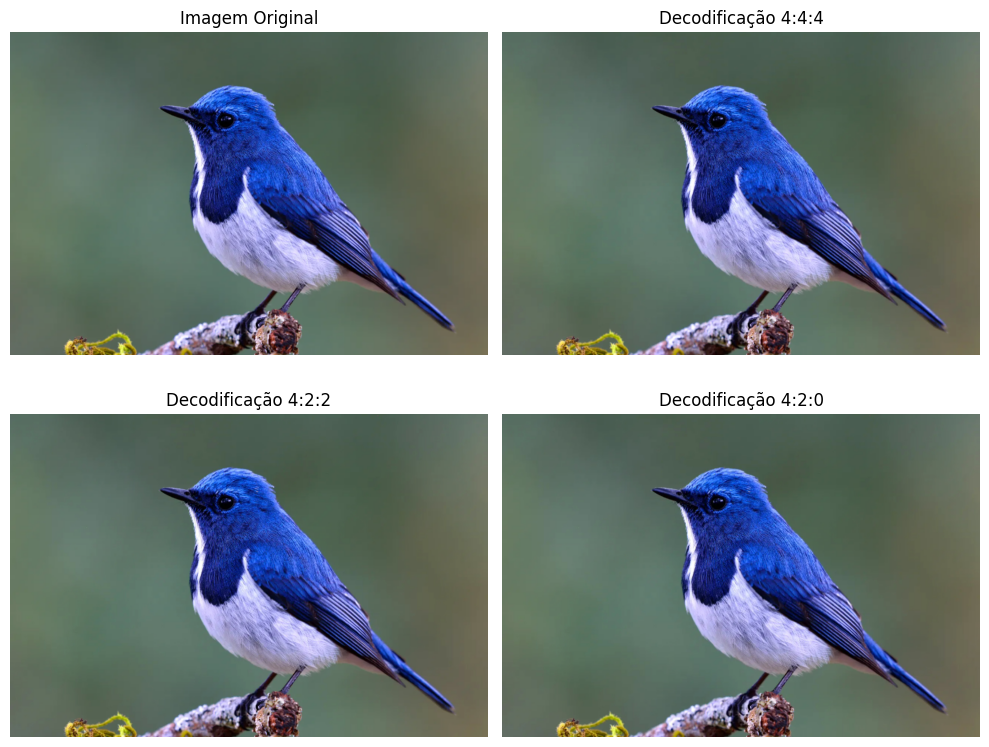

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Removendo os eixos em todas as imagens
for ax in axs.ravel():
    ax.axis('off')

# Exibindo as imagens
axs[0, 0].imshow(img_original_rgb)
axs[0, 0].set_title('Imagem Original')

axs[0, 1].imshow(img_decodficada_444)
axs[0, 1].set_title('Decodificação 4:4:4')

axs[1, 0].imshow(img_decodficada_422)
axs[1, 0].set_title('Decodificação 4:2:2')

axs[1, 1].imshow(img_decodficada_420)
axs[1, 1].set_title('Decodificação 4:2:0')

# Ajustando o espaçamento entre as subplots
plt.tight_layout()

# Exibindo a figura
plt.show()

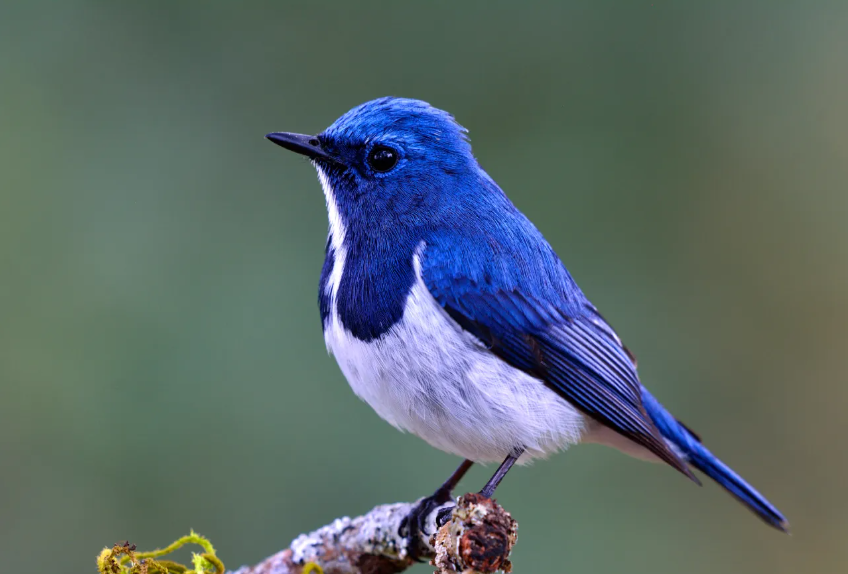

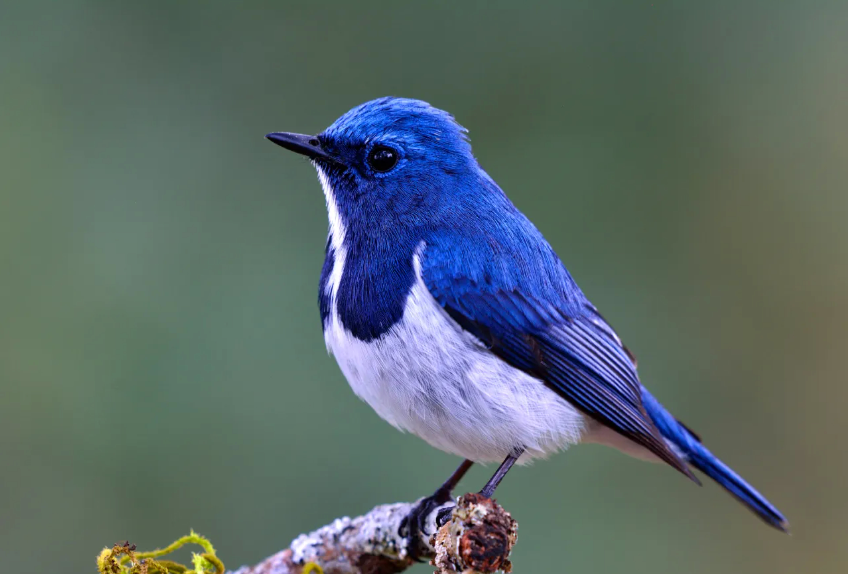

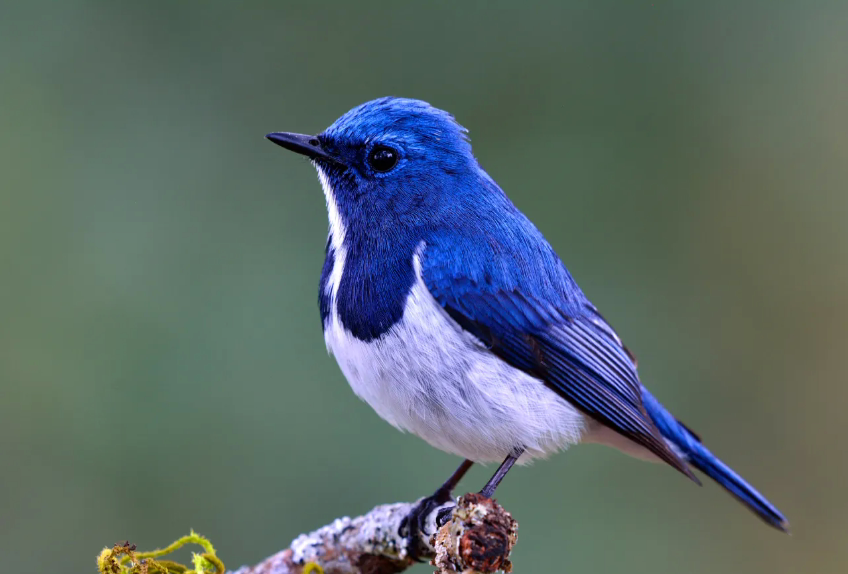

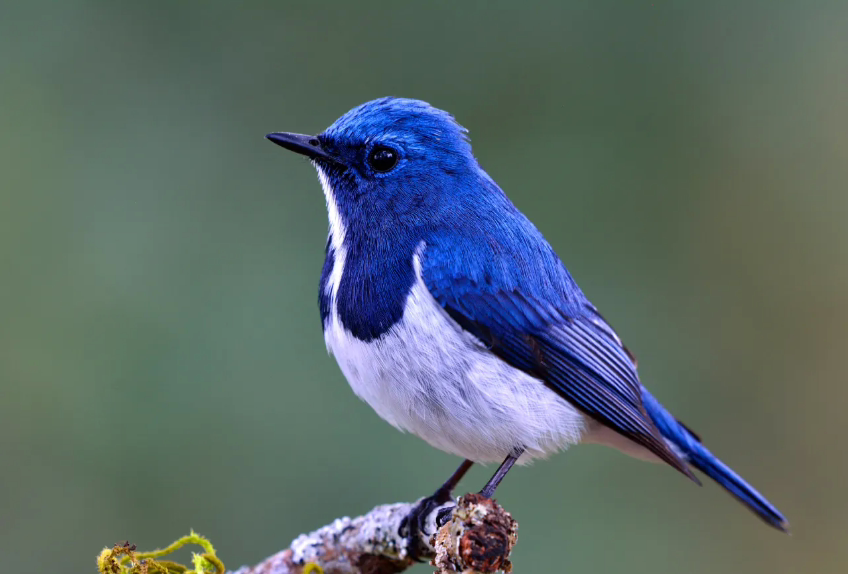

In [43]:
# Exibindo as imagens
cv2_imshow(cv2.cvtColor(img_original_rgb, cv2.COLOR_RGB2BGR))
cv2_imshow(cv2.cvtColor(img_decodficada_444, cv2.COLOR_RGB2BGR))
cv2_imshow(cv2.cvtColor(img_decodficada_422, cv2.COLOR_RGB2BGR))
cv2_imshow(cv2.cvtColor(img_decodficada_420, cv2.COLOR_RGB2BGR))

##### Calculando o PSNR

In [44]:
# Avaliando qualidade baseada no PSNR
print(f'IMAGENS COMPARADAS      PSNR (dB)')
print(f'Original vs Original    {calculaPSNR(img_original_rgb, img_original_rgb)}')
print(f'Original vs 4:4:4       {calculaPSNR(img_original_rgb, img_decodficada_444)}')
print(f'Original vs 4:2:2       {calculaPSNR(img_original_rgb, img_decodficada_422)}')
print(f'Original vs 4:2:0       {calculaPSNR(img_original_rgb, img_decodficada_420)}')

IMAGENS COMPARADAS      PSNR (dB)
Original vs Original    inf
Original vs 4:4:4       52.51436928072871
Original vs 4:2:2       42.81918086759183
Original vs 4:2:0       40.66603590508136


In [45]:
print(f'Original vs Original    {cv2.PSNR(img_original_rgb,img_original_rgb)}')
print(f'Original vs 4:4:4       {cv2.PSNR(img_original_rgb,img_decodficada_444)}')
print(f'Original vs 4:2:2       {cv2.PSNR(img_original_rgb,img_decodficada_422)}')
print(f'Original vs 4:2:0       {cv2.PSNR(img_original_rgb,img_decodficada_420)}')

Original vs Original    361.20199909921956
Original vs 4:4:4       52.514369381424814
Original vs 4:2:2       42.81918073252454
Original vs 4:2:0       40.666036087412074


## 2ª Etapa: **Segmentação 8x8 e DCT**

### Definições

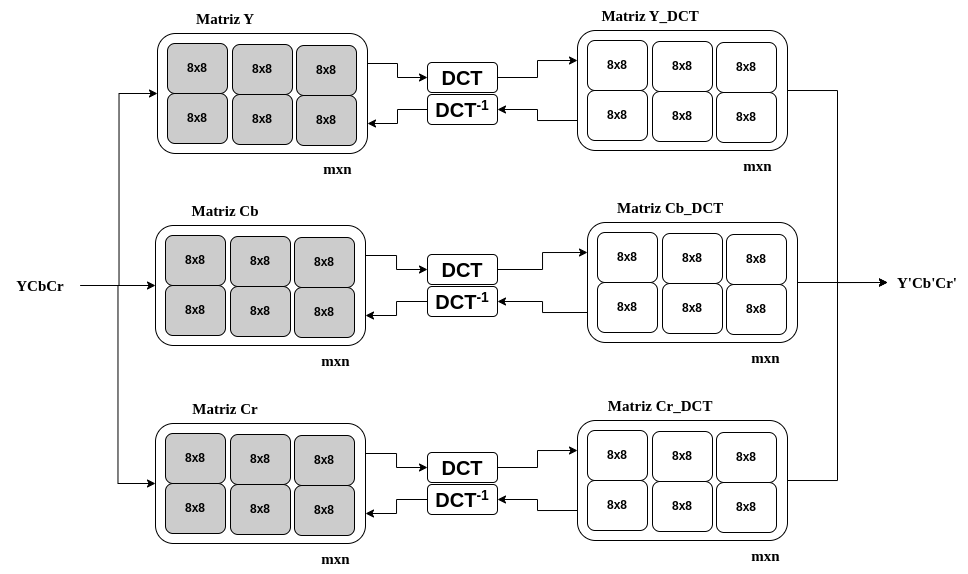

### Implementação

### Testes